## Titanic Machine Learning

This project is to use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. Train.csv contains the details of a subset of 891 passengers on board. This notebook is a step-by-step overview of my data analysis. **It includes a detailed process of data wrangling, exploratory data analysis, and a randomforest tree modeling**. Through analysis, I finally determined eight features, built a classification model, and achieved an accuracy of 0.81. <br>
<br> I will present my analysis in the following order:
<ul>
    <li>1. Data Import</li>
    <li>2. Data Visualization and Exploratory Analysis</li>
    <ul>
        <li>2.1 Sex</li>
        <li>2.2 Fare</li>
        <li>2.3 Embarked</li>
        <li>2.4 'SibSp', 'Parch' and 'Total Relations'</li>
        <li>2.5 Name, Title and Name Length</li>
        <li>2.6 Ticket</li>
    </ul>
    <li>3. Dealing with Outliers and Missing Data</li>
    <ul>
        <li>3.1 Cabin</li>
        <li>3.2 Embarked</li>
        <li>3.3 Age</li>
    </ul>
    <li>4. Feature Engineering</li>
    <ul>
        <li>4.1 Process Test Data</li>
        <li>4.2 Encoding Categorical Variables</li>
    </ul>
    <li>5. Model Built and Tuning</li>
    <li>6. Results</li>
</ul>    

In [1]:
# read data
import numpy as np 
import pandas as pd

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Import

First, I imported and read the data. I found that 'Age' and 'Cabin' are missing a relative large proportion of data. 'PassengerId' may not reveal anything important, so I will probably drop it after a servious check. Through a rough correlation calculation, I found that 'Fare' and 'Pclass' clearly are more correlated with 'Survived'.  

In [2]:
df = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.corr()['Survived'].sort_values(ascending=False) # a rough correlation test

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

## 2. Data Visualization and Exploratory Analysis

In this section, I will mainly focus on examining whether and how each variable is realted with the 'Survived'. I will use mathmatical calculations and visual plots to reveal each relationships, and thus formulate hypothesis on the relationship between each variable and the 'Survival' rate. 

### 2.1 Sex
It is found that, in terms of 'Sex', 'Female' are more likely to be survived. 

In [5]:
df[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


Text(0.5, 1.0, 'Figure 1. Sex VS Survived')

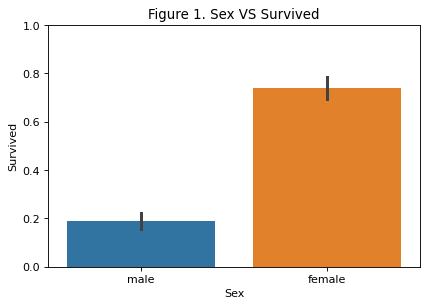

In [6]:
plt.figure(dpi=80)
sns.barplot(data=df,y='Survived',x='Sex')
plt.ylim(0, 1)
plt.title('Figure 1. Sex VS Survived')

### 2.2 Fare
Clearly, higher ticket fares resulted in higher survival rates. 

In [7]:
df.groupby('Survived').mean()['Fare']

Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64

<Figure size 480x320 with 0 Axes>

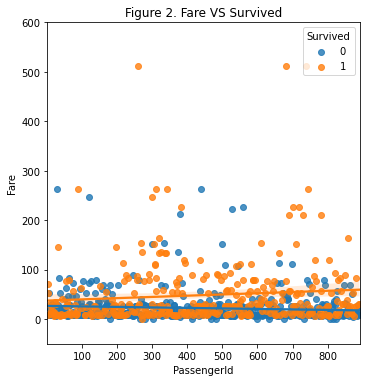

In [8]:
plt.figure(dpi=80)
sns.lmplot(data=df, x='PassengerId', y='Fare', hue='Survived',legend=False) # Survived people tend to have higher priced tickets
sns.despine(right=False,top=False)
plt.ylim(-50, 600)
plt.title('Figure 2. Fare VS Survived')
plt.legend(loc='upper right',title='Survived')

### 2.3 Embarked
It is hypothesed that people departed from different wharfs may have different survival rates. From the summerized data, I can find that people departed from 'C' clearly have a higher survival rate. Meantime, there were no big differences between people departed from 'Q' and 'S'. A correlation analysis is done to show that departed from 'C' and 'S' have some correlations with 'Survived'. This variable can be included in a RandomForest Tree model. 

In [9]:
df[['Embarked', 'Survived']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


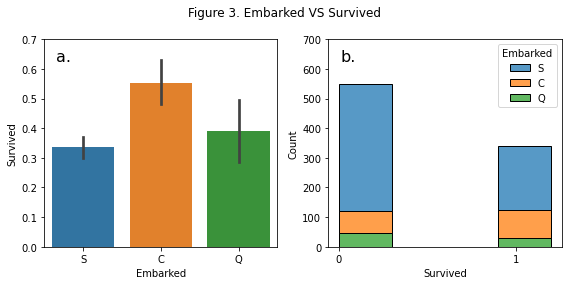

In [10]:
fig, axes = plt.subplots(1, 2,figsize=(8, 4))
fig.suptitle('Figure 3. Embarked VS Survived')

sns.barplot(data=df, x='Embarked', y='Survived', ax=axes[0])
axes[0].set_ylim(0, 0.7)

sns.histplot(data=df, x='Survived', hue='Embarked', ax=axes[1], multiple='stack', binwidth=0.3)
axes[1].set_ylim(0, 700)
axes[1].set_xticks([0, 1])

for i, label in enumerate(('a.', 'b.')):
    axes[i].text(0.05, 0.95, label, transform=axes[i].transAxes,
      fontsize=16, va='top')

plt.tight_layout()

In [11]:
pd.concat([pd.get_dummies(df['Embarked']), df['Survived']], axis=1).corr()

,C,Q,S,Survived
C,1.000000,-0.148258,-0.778359,0.16824
Q,-0.148258,1.000000,-0.496624,0.00365
S,-0.778359,-0.496624,1.000000,-0.15566
Survived,0.168240,0.003650,-0.155660,1.00000


### 2.4 'SibSp', 'Parch' and 'Total Relations'
'SibSp' and 'Parch' are both variables that reveal the relations of each passenger on the cruise. It can be hypothesed that people with more relations may have a higher 'Survival' rate because they can receive a stronger help and support from their relations during the escape. It can also hypothesed the opposite---people alone on the cruise may easier to escape because they have no 'obligations' to help or support others. The data helped to reveal the latter hypothesis is right---people with less than 3 'SibSp' had a higher survival rate. The figures are shown in Figures 4a and 4b. 

In [12]:
df[['Survived','SibSp']].groupby('SibSp').mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [13]:
df[['Survived','SibSp']].corr()

,Survived,SibSp
Survived,1.000000,-0.035322
SibSp,-0.035322,1.000000


The same applies to 'Parch'. People with less than 3 'Parch' had a higher survival rate.

In [14]:
df[['Parch','Survived']].groupby('Parch').mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


In [15]:
df[['Parch','Survived']].corr()

,Parch,Survived
Parch,1.000000,0.081629
Survived,0.081629,1.000000


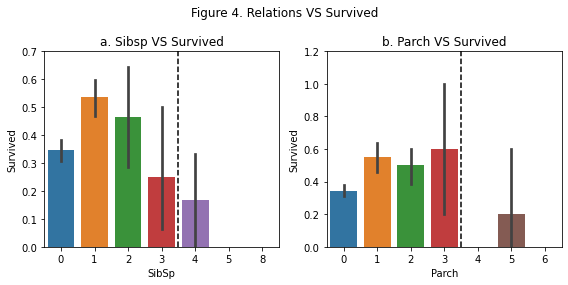

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Figure 4. Relations VS Survived')

sibsp_survived = sns.barplot(data=df, x='SibSp', y='Survived', ax=axes[0])
sibsp_survived.axvline(x=3.5,ls='--', color='black')# people with less than 3 'SibSp' had a higher survival rate
axes[0].set_title('a. Sibsp VS Survived')
axes[0].set_ylim(0, 0.7)

parch_survived = sns.barplot(data=df, x='Parch', y='Survived', ax=axes[1])
parch_survived.axvline(x=3.5, ls='--',color='black')
axes[1].set_title('b. Parch VS Survived')
axes[1].set_ylim(0, 1.2)

plt.tight_layout()

In [17]:
df['total_relations'] = df['Parch'] + df['SibSp']
df[['total_relations', 'Survived']].groupby('total_relations').mean()

,Survived
total_relations,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


Text(0.5, 1.0, 'Figure 5. Total_Relations VS Survived')

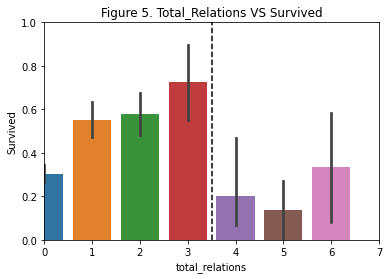

In [18]:
total_relations_survived = sns.barplot(data=df, x='total_relations', y='Survived')
total_relations_survived.axvline(x=3.5, ls='--',color='black')
plt.ylim(0, 1)
plt.xlim(0, 7)
plt.title('Figure 5. Total_Relations VS Survived')

In [19]:
df[['total_relations', 'Survived']].corr()

,total_relations,Survived
total_relations,1.000000,0.016639
Survived,0.016639,1.000000


Since less than or equal to 3 relations resulted in a higher survival rate, here I classified the total relations to 'alone', 'a few', and 'many' based on if relations is 0 or fewer or larger than 3. It turns out this relationship shows a good coorelation factor with 'Survived'. 

In [20]:
def travel_relation(num):
    if num == 0:
        return 'alone'
    elif num <=3:
        return 'a few'
    else:
        return 'many'

In [21]:
df['travel_relation_status'] = np.vectorize(travel_relation)(df['total_relations'])
df['travel_relation_status']

0      a few
1      a few
2      alone
3      a few
4      alone
       ...  
886    alone
887    alone
888    a few
889    alone
890    alone
Name: travel_relation_status, Length: 891, dtype: object

In [22]:
pd.concat([pd.get_dummies(df['travel_relation_status']), df['Survived']], axis=1).corr()

,a few,alone,many,Survived
a few,1.000000,-0.859931,-0.190940,0.279855
alone,-0.859931,1.000000,-0.336825,-0.203367
many,-0.190940,-0.336825,1.000000,-0.125147
Survived,0.279855,-0.203367,-0.125147,1.000000


### 2.5 Name, Title and Name Length
There is no obvious relations between 'Name' and 'Survival'. But I observed that the second term in each name is the title of each person, which reveals each person's social class or positions. In those years, higher class people may have earlier chances to evacuate in lifeboats. In below analysis, the data clearly shows so. 

In [23]:
df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [24]:
def title(name):
    return name.split(',')[1].split('.')[0]

In [25]:
df['title'] = np.vectorize(title)(df['Name'])
df['title'] = df['title'].str.strip()
df['title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Jonkheer          1
Capt              1
the Countess      1
Don               1
Ms                1
Mme               1
Sir               1
Lady              1
Name: title, dtype: int64

Since there are too many titles, which can put noises on the analysis. I will simply categorize the titles into four categories, i.e. Miss, Mr, Mrs, and Others.

In [26]:
title_dic = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs':'Mrs', 'Master': 'Mr', 'Dr': 'Mr', 'Rev': 'Mr', 'Major': 'Mr', 'Col': 'Mr', 'Mlle': 'Miss',
            'Sir': 'Mr', 'Capt': 'Mr', 'Jonkheer': 'Miss', 'Lady':'Mrs', 'Don': 'Mrs', 'the Countess': 'Miss','Mme': 'Mrs', 'Ms': 'Mrs'}

df['final_title'] = df['title'].map(title_dic)
df['final_title'].value_counts()

Mr      576
Miss    186
Mrs     129
Name: final_title, dtype: int64

Clearly, titles have a moderate correlation with 'Survived'. 

In [27]:
pd.concat([pd.get_dummies(df['final_title']), df['Survived']], axis=1).corr() #strong correlations

,Miss,Mr,Mrs,Survived
Miss,1.000000,-0.694573,-0.211339,0.332790
Mr,-0.694573,1.000000,-0.556382,-0.536279
Mrs,-0.211339,-0.556382,1.000000,0.344223
Survived,0.332790,-0.536279,0.344223,1.000000


Text(0.5, 1.0, 'Figure 6. Titles VS Survived')

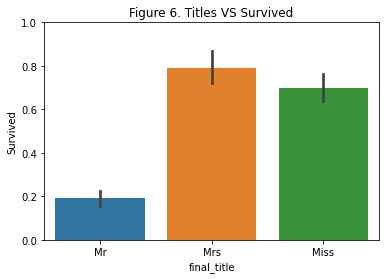

In [28]:
sns.barplot(data=df, x='final_title', y='Survived')
plt.ylim(0, 1.0)
plt.title('Figure 6. Titles VS Survived')

Similarly, a longer name length may reveal a higher class, which means an earilier chance to evacuate in lifeboats. So I also extract the information of name lengths. 

In [29]:
df['name_len'] = np.vectorize(len)(df['Name'])
df['name_len'].value_counts()

19    64
25    55
27    50
18    50
26    49
28    43
24    43
17    42
21    40
23    39
20    39
22    38
30    37
29    32
31    30
16    26
32    23
33    22
15    15
47    11
37    10
38     9
36     9
39     9
45     9
44     8
41     8
34     7
46     7
40     7
51     7
35     6
43     5
42     5
49     5
50     4
52     4
56     3
14     3
48     3
13     2
12     2
53     2
55     2
57     2
67     1
54     1
61     1
65     1
82     1
Name: name_len, dtype: int64

Text(0.5, 1.0, 'Figure 7. Name Length VS Survived')

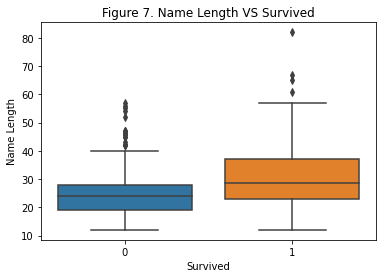

In [30]:
name_len_survived = sns.boxplot(data=df,x='Survived', y='name_len')
name_len_survived.set_ylabel('Name Length')
plt.title('Figure 7. Name Length VS Survived')

### 2.6 Ticket

Ticket numbers may be random. I did not find any obvious patterns of ticket numbers. It is hypothesed that ticket numbers may reveal seat/room positions on the cruise. A seat/room that is more close to the lifeboats may give passengers more chance to survive. However, through the analysis of the first number of tickets, no obvious correlations with 'Survived' is found. 

In [31]:
df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [32]:
def ticket_number(ticket):
    if not ticket[0].isnumeric():
        return ticket.split()[-1][0]
    else:
        return ticket[0]

In [33]:
df['ticket_first_number'] = np.vectorize(ticket_number)(df['Ticket'])
df['ticket_first_number'] .value_counts()
ticket_dic = {'L': '7'}
df['ticket_first_number'] = df['ticket_first_number'].replace('L', '7')
df['ticket_first_number'].value_counts()

3    367
1    231
2    230
7     19
4     15
6     14
5      9
8      3
9      3
Name: ticket_first_number, dtype: int64

In [34]:
df.groupby('ticket_first_number').mean()['Survived']

ticket_first_number
1    0.606061
2    0.408696
3    0.258856
4    0.133333
5    0.222222
6    0.071429
7    0.263158
8    0.000000
9    1.000000
Name: Survived, dtype: float64

## 3. Dealing with Outliers and Missing Data
There are a large proportion of 'Cabin' and 'Age' data are missing.

In [35]:
df.isnull().sum().sort_values(ascending=False)

Cabin                     687
Age                       177
Embarked                    2
ticket_first_number         0
Parch                       0
Survived                    0
Pclass                      0
Name                        0
Sex                         0
SibSp                       0
Ticket                      0
name_len                    0
Fare                        0
total_relations             0
travel_relation_status      0
title                       0
final_title                 0
PassengerId                 0
dtype: int64

### 3.1 Cabin

I first fill null value in 'Cabin' with 'N'. It is hypothsed that the first letter of 'Cabin' reveal the cabin class,and various cabin classes have different 'Survival' rates. However, no obvious relations are identified in the later analysis. An extra random forest classifier feature importance analysis also reveals that the 'cabin class' is not an important feature (not included in this file). Therefore I will not include 'Cabin' in the further modeling. 

In [36]:
df['Cabin']= df['Cabin'].fillna('N')
df['Cabin']

0         N
1       C85
2         N
3      C123
4         N
       ... 
886       N
887     B42
888       N
889    C148
890       N
Name: Cabin, Length: 891, dtype: object

In [37]:
def cabin_class(cabin):
    return cabin[0]

df['cabin_class'] = np.vectorize(cabin_class)(df['Cabin'])
df['cabin_class'].value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_class, dtype: int64

In [38]:
df.groupby('cabin_class').mean()['Survived']

cabin_class
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
N    0.299854
T    0.000000
Name: Survived, dtype: float64

Text(0.5, 1.0, 'Figure 8. Cabin_Class VS Survived')

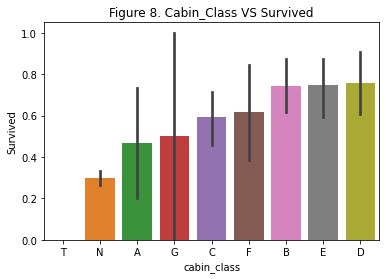

In [39]:
order = ['T', 'N', 'A', 'G', 'C', 'F', 'B', 'E', 'D']
sns.barplot(data=df, x='cabin_class', y='Survived',order=order)
plt.title('Figure 8. Cabin_Class VS Survived')

### 3.2 Embarked

There are two 'Embarked' Data missing. My hypothesis is that, if travelers are in the same class, in the same cabin, and having the same ticket fare, they should depart from the same location. However, I cannot recover 'Embarked' by this hypothesis. So I decide to drop these two missing data.

In [40]:
embarked_missing = df[df['Embarked'].isna()]
df[df['Fare'] == embarked_missing['Fare'].iloc[0]]
df[df['Ticket'] == embarked_missing['Ticket'].iloc[0]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relations,travel_relation_status,title,final_title,name_len,ticket_first_number,cabin_class
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,alone,Miss,Miss,19,1,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,alone,Mrs,Mrs,41,1,B


Since there is no way to find missing 'Embarked' data, I will simply drop two lines data.

In [41]:
df[df['Embarked'].isnull()]
df.dropna(subset=['Embarked'], axis=0, inplace=True) # drop the two rows that missing embarked data

In [42]:
df[df['Embarked'].isnull()] # double check if the two rows have been dropped

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relations,travel_relation_status,title,final_title,name_len,ticket_first_number,cabin_class


### 3.3 Age

Since ages are missing, but age is more likely to be related with the survival rate, so I will fill missing 'Age' with mean 'Age' data group by 'title' and 'Pclass'.

final_title  Pclass
Miss         1         29.812500
             2         22.390625
             3         16.123188
Mr           1         41.404200
             2         30.740707
             3         26.507589
Mrs          1         40.000000
             2         33.547619
             3         33.515152
Name: Age, dtype: float64

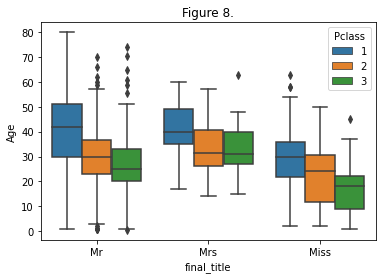

In [43]:
sns.boxplot(data=df, x='final_title', y='Age', hue='Pclass')
plt.title('Figure 8.')

data=df.groupby(['final_title', 'Pclass']).mean()['Age']
data

In [44]:
df['Age'] = df['Age'].fillna(df.groupby(['final_title', 'Pclass']).transform('mean')['Age'].round(0))
df['Age'].isnull().sum()

0

In [45]:
df['Age'].corr(df['Survived'])

-0.07186125072690736

### 4. Feature Engineering

After reviewing and cleaning data, I will prepare the data for further modeling. Meanwhile, I will use the same method to process test data.

In [46]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'total_relations',
       'travel_relation_status', 'title', 'final_title', 'name_len',
       'ticket_first_number', 'cabin_class'],
      dtype='object')

In [47]:
df_drop = df.drop(['PassengerId', 'Name', 'Ticket', 'total_relations', 'Cabin', 'title', 'total_relations'], axis=1)
df_drop2 = df_drop.drop(['ticket_first_number', 'cabin_class'], axis=1)

In [48]:
df_drop2.isnull().sum() #double check if there is any missing data after cleaning

Survived                  0
Pclass                    0
Sex                       0
Age                       0
SibSp                     0
Parch                     0
Fare                      0
Embarked                  0
travel_relation_status    0
final_title               0
name_len                  0
dtype: int64

### 4.1 Processing Test Data

In [49]:
test = pd.read_csv('test.csv')
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [50]:
# use the same method to process 'total_relations' data in the test dataset
def travel_relation(num):
    if num == 0:
        return 'alone'
    elif num <=3:
        return 'a few'
    else:
        return 'many'

In [51]:
# use the same method to map the titles in the test dataset, generate a new column 'name_len' in the test dataset
def title(name):
    return name.split(',')[1].split('.')[0]

test['total_relations'] = test['Parch'] + test['SibSp']
test['travel_relation_status'] = np.vectorize(travel_relation)(test['total_relations'])
test['title'] = np.vectorize(title)(test['Name'])
test['title'] = test['title'].str.strip()
title_dic = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs':'Mrs', 'Master': 'Mr', 'Dr': 'Mr', 'Rev': 'Mr', 'Major': 'Mr', 'Col': 'Mr', 'Mlle': 'Miss',
            'Sir': 'Mr', 'Capt': 'Mr', 'Jonkheer': 'Miss', 'Lady':'Mrs', 'Don': 'Mrs', 'the Countess': 'Miss','Mme': 'Mrs', 'Ms': 'Mrs', 'Rev': 'Mr', 'Dona':'Mrs', 'Dr':'Mr'}
test['final_title'] = test['title'].map(title_dic)

test['name_len'] = np.vectorize(len)(test['Name'])

In [52]:
# fill in the Nan values in the test dataset
test['Fare'] = test['Fare'].fillna(round(test[test['Pclass'] == 3]['Fare'].mean(), 2))
test['Age'] = test['Age'].fillna(test.groupby(['final_title', 'Pclass']).transform('mean')['Age'].round(0))

In [53]:
# drop useless columns in the test dataset, so that the columns in the test would be the same of those in the prediction df
test_drop = test.drop(['PassengerId', 'Name', 'Ticket', 'total_relations', 'Cabin', 'title', 'total_relations'], axis=1)

### 4.2 Encoding Categorical Variables

In [54]:
# separate the prediction df into categorical data and numeric data parts
# get dummies of the categorical data, combine it with numeric data
# so that we can get the dataset which is ready to be modeled. 
df_object = df_drop2.select_dtypes(include='object')
df_object_dummies = pd.get_dummies(df_object, drop_first=True)
df_numeric = df_drop2.select_dtypes(exclude='object')
final_df = pd.concat([df_numeric, df_object_dummies], axis=1).drop(['SibSp', 'Parch'], axis=1)
final_df

,Survived,Pclass,Age,Fare,name_len,Sex_male,Embarked_Q,Embarked_S,travel_relation_status_alone,travel_relation_status_many,final_title_Mr,final_title_Mrs
0,0,3,22.0,7.2500,23,1,0,1,0,0,1,0
1,1,1,38.0,71.2833,51,0,0,0,0,0,0,1
2,1,3,26.0,7.9250,22,0,0,1,1,0,0,0
3,1,1,35.0,53.1000,44,0,0,1,0,0,0,1
4,0,3,35.0,8.0500,24,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,21,1,0,1,1,0,1,0
887,1,1,19.0,30.0000,28,0,0,1,1,0,0,0
888,0,3,16.0,23.4500,40,0,0,1,0,0,0,0
889,1,1,26.0,30.0000,21,1,0,0,1,0,1,0


In [76]:
test_object = test_drop.select_dtypes(include='object')
test_object_dummies = pd.get_dummies(test_object, drop_first=True)
test_numeric = test_drop.select_dtypes(exclude='object')
final_test = pd.concat([test_numeric, test_object_dummies], axis=1).drop(['SibSp', 'Parch'], axis=1)

## 5. Model Built and Tuning

I choose a randomforest classification model to train the data. After building and tuning the model, it achieves an accuracy of 0.83. 

In [58]:
# data preparation
X = final_df.drop(['Survived'], axis=1)
y = final_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# model pipeline built
n_estimators = [5, 10, 20, 50,70]
max_features = [1, 2, 3, 4]
bootstrap = [True, False]
oob_score = [True, False]
criterion = ['gini', 'entropy']
min_samples_split = [1, 2, 5]
min_samples_leaf = [1, 2, 5]
param_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'bootstrap': bootstrap, 'oob_score': oob_score, 'criterion': criterion
             , 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
rfc = RandomForestClassifier()
grid_model = GridSearchCV(rfc, param_grid, cv=10)

In [62]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [1, 2, 5],
                         'n_estimators': [5, 10, 20, 50, 70],
                         'oob_score': [True, False]})

In [63]:
grid_model.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_features': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50,
 'oob_score': True}

In [64]:
y_pred = grid_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       109
           1       0.76      0.77      0.76        69

    accuracy                           0.81       178
   macro avg       0.80      0.81      0.81       178
weighted avg       0.82      0.81      0.81       178



Tune key parameters again based on the last cross validation result. 

In [65]:
n_estimators2 = [10,20,30,40, 50]
max_features2 = [3, 4, 5, 6, 7, 10]
bootstrap2 = [True, False]
oob_score2 = [True, False]
criterion2 = ['gini', 'entropy']
min_samples_split2 = [1, 2, 5]
min_samples_leaf2 = [1, 2, 5]
param_grid2 = {'n_estimators': n_estimators2, 'max_features': max_features2, 'bootstrap': bootstrap2, 'oob_score': oob_score2, 
               'criterion': criterion2, 'min_samples_split': min_samples_split2, 'min_samples_leaf': min_samples_leaf2}
rfc2 = RandomForestClassifier()
grid_model2 = GridSearchCV(rfc2, param_grid2, cv=10)

In [66]:
grid_model2.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_features': [3, 4, 5, 6, 7, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [1, 2, 5],
                         'n_estimators': [10, 20, 30, 40, 50],
                         'oob_score': [True, False]})

In [67]:
grid_model2.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 40,
 'oob_score': False}

In [68]:
final_rfc = RandomForestClassifier(n_estimators=40, max_features=3, oob_score=False, bootstrap=True)
final_rfc.fit(X_train, y_train)

RandomForestClassifier(max_features=3, n_estimators=40)

In [69]:
final_rfc.feature_importances_

array([0.08749878, 0.1859965 , 0.19621753, 0.17537664, 0.14869473,
       0.00969614, 0.02568921, 0.01789722, 0.03649654, 0.0923737 ,
       0.02406303])

In [71]:
pd.concat((pd.DataFrame(final_df.iloc[:, 1:].columns, columns = ['variable']), pd.DataFrame(final_rfc.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)#show feature importance

,variable,importance
2,Fare,0.196218
1,Age,0.185997
3,name_len,0.175377
4,Sex_male,0.148695
9,final_title_Mr,0.092374
0,Pclass,0.087499
8,travel_relation_status_many,0.036497
6,Embarked_S,0.025689
10,final_title_Mrs,0.024063
7,travel_relation_status_alone,0.017897


In [72]:
y_pred2 = grid_model2.predict(X_test)
print(classification_report(y_test, y_pred2)) # it achieves an accuracy of 0.83. 

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       109
           1       0.78      0.77      0.77        69

    accuracy                           0.83       178
   macro avg       0.82      0.82      0.82       178
weighted avg       0.83      0.83      0.83       178



## 6. Results

In [78]:
final_pred = grid_model2.predict(final_test)

In [79]:
final_pred = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived': final_pred})

In [80]:
final_pred.to_csv('result.csv', index=False)# save results to a csv file 